# **Plates**

## Step 1 : Mesh

In [1]:
from dewloosh.mesh.rgrid import gridQ4
import numpy as np

size = Lx, Ly = (20, 5)
shape = nx, ny = (40, 20)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coordsQ4_, topoQ4 = gridQ4(**gridparams)
coordsQ4 = np.zeros((coordsQ4_.shape[0], 3))
coordsQ4[:, :2] = coordsQ4_[:, :]


## Step 2 : Material

In [2]:
E = 12000.
nu = 0.2
t = 0.25
D = np.array([
    [1, nu, 0, 0, 0], 
    [nu, 1, 0, 0, 0],
    [0, 0, (1-nu)/2, 0, 0], 
    [0., 0, 0, 0, 0],
    [0., 0, 0, 0, 0]]) * (t**3 * E / (1-nu**2))/12
S = np.array([
    [0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0], 
    [0., 0, 0, 5*(1-nu)/12, 0],
    [0., 0, 0, 0, 5*(1-nu)/12]]) * (t * E / (1-nu**2))
A = D + S

## Step 3 : Boundary Conditions

In [3]:
# fix points at x==0
cond = coordsQ4[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coordsQ4.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, :2] = True
fixity[:, -1] = True

# unit vertical load at (Lx, Ly)
F = 10
loads = np.zeros((coordsQ4.shape[0], 6))

cond = (coordsQ4[:, 0] > (Lx-(1e-12))) & (coordsQ4[:, 1] > (Ly-(1e-12)))
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = -F

cond = (coordsQ4[:, 0] > (Lx-(1e-12))) & (coordsQ4[:, 1] < (1e-12))
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = F


## Step 4 : Assembly and Solution

In [4]:
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon import Structure, FemMesh
from sigmaepsilon.fem.elib import Q4P as Q4

GlobalFrame = StandardFrame(dim=3)
meshQ4 = FemMesh(coords=coordsQ4, topo=topoQ4, model=A, fixity=fixity,
                 loads=loads, celltype=Q4)
structure = Structure(mesh=meshQ4)
structure.linsolve()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coordsQ4 + dofsol[:, :3]

## Step 5 : Plotting

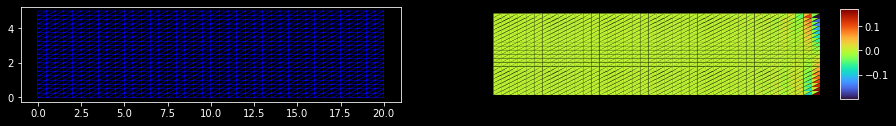

In [5]:
%matplotlib inline
from dewloosh.mesh.topo.tr import Q4_to_T3
from dewloosh.mesh.tri.triang import triangulate
from dewloosh.mesh.tri.triplot import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use('dark_background')

points, triangles = Q4_to_T3(structure.mesh.coords(), topoQ4)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

fig = plt.figure(figsize=(15, 4))  # in inches
fig.patch.set_facecolor('black')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig,
        data=dofsol[:, 2], cmap='turbo', axis='off')
